In [1]:
import os
import json
import glob
import copy
import copy
import itertools
import pprint 
pp = pprint.PrettyPrinter(indent=4)

import numpy as np
import pylab as pl
import seaborn as sns
import pandas as pd
import statsmodels as sm
import cPickle as pkl

from scipy import stats as spstats

#from pipeline.python.retinotopy import fit_2d_rfs as fitrf
#from pipeline.python.retinotopy import convert_coords as coords

from pipeline.python.classifications import experiment_classes as util
#from pipeline.python.classifications import retino_structure as ret
from pipeline.python.classifications import aggregate_data_stats as aggr
#from pipeline.python.classifications import rf_utils as rfutils

from pipeline.python import utils as putils #.utils import natural_keys, label_figure, convert_range

from matplotlib.lines import Line2D

import matplotlib.patches as patches

In [2]:
# def melt_square_matrix(df, metric_name='value', add_values={}, include_diagonal=False):
    
#     k = 0 if include_diagonal else 1
#     df = df.where(np.triu(np.ones(df.shape), k=k).astype(np.bool))

#     df = df.stack().reset_index()
#     df.columns=['row', 'col', metric_name]
    
#     if len(add_values) > 0:
#         for k, v in add_values.items():
#             df[k] = [v for _ in np.arange(0, df.shape[0])]
    
#     return df

In [3]:
from scipy import interpolate
def resample_traces(samples, in_rate=44.65, out_rate=20.0):

    n_in_samples= len(samples)
    in_samples = samples.copy() #[rid, :] #np.array(tracef['File%03d' % curr_file][trace_type][:])
    in_tpoints = np.arange(0, n_in_samples) #len(in_samples))

    n_out_samples = round(n_in_samples * out_rate/in_rate)
    #print("N out samples: %i" % n_out_samples)

    flinear = interpolate.interp1d(in_tpoints, in_samples, axis=0)

    out_tpoints = np.linspace(in_tpoints[0], in_tpoints[-1], n_out_samples)
    out_samples = flinear(out_tpoints)
    #print("Out samples:", out_samples.shape)
    
    return out_tpoints, out_samples


In [1361]:
# import math
# def fastdist(v1, v2):
#     dist = [(a - b)**2 for a, b in zip(v1, v2)]
#     dist = math.sqrt(sum(dist))
#     return dist

In [5]:
%matplotlib notebook

# Colors

In [6]:
# # visual_areas = ['V1', 'Lm', 'Li']
# # colors = ['k', 'royalblue', 'darkorange'] #sns.color_palette(palette='colorblind') #, n_colors=3)
# # area_colors = {'V1': colors[0], 'Lm': colors[1], 'Li': colors[2]}
# visual_areas = ['V1', 'Lm', 'Li']
# colors = ['magenta', 'orange', 'dodgerblue'] #sns.color_palette(palette='colorblind') #, n_colors=3)
# area_colors = {'V1': colors[0], 'Lm': colors[1], 'Li': colors[2]}

# #### Plot params
# pl.rcParams["axes.labelsize"] = 16
# pl.rcParams["xtick.labelsize"] = 12
# pl.rcParams["ytick.labelsize"] = 12

# dpi = 150

In [1007]:
reload(putils)

<module 'pipeline.python.utils' from '/home/julianarhee/Repositories/2p-pipeline/pipeline/python/utils.py'>

In [1008]:
visual_area, area_colors = putils.set_threecolor_palette()
dpi = putils.set_plot_params()


# Dataset info

In [881]:
#### Set trace ID and FOV/state type
traceid = 'traces001'
fov_type = 'zoom2p0x'
state = 'awake'
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'

#### Preprocessing params
responsive_test = 'nstds' # 'nstds' #'ROC' #None
nstd_thr=10

responsive_thr = 0.05 if responsive_test=='nstds' else nstd_thr #0.05 #None
n_stds = None if responsive_test=='ROC' else 2.5 #None

#### RF fit params
response_type = 'dff'

response_str = '%s_resptest-%s_respthr-%.2f' % (response_type, responsive_test, responsive_thr) 

In [882]:
if not os.path.exists(os.path.join(aggregate_dir, 'responsivity', responsive_test)):
    os.makedirs(os.path.join(aggregate_dir, 'responsivity', responsive_test))

In [883]:
#### Create data ID for labeling figures with data-types
experiment = 'gratings'

filter_by = 'first'

if experiment=='blobs':
    has_gratings=False
    g_str = 'hasgratings' if has_gratings else 'blobsonly'
else:
    g_str = 'gratingsonly'
filter_str = 'filter-dsets-%s-%s_%s' % (filter_by, g_str, response_str)


In [884]:
#### Create data ID for labeling figures with data-types
data_id = '|'.join([traceid, filter_str])
print(data_id)


traces001|filter-dsets-first-gratingsonly_dff_resptest-nstds_respthr-0.05


In [885]:
#### Output dir
stats_dir = os.path.join(aggregate_dir, 'data-stats')

In [886]:
# Get all data sets
sdata = aggr.get_aggregate_info(traceid=traceid, fov_type=fov_type, state=state)
sdata[['visual_area', 'animalid', 'session', 'fov']].drop_duplicates().groupby(['visual_area']).count()

,animalid,session,fov
visual_area,,,
Li,26,26,26
Lm,22,22,22
V1,18,18,18


In [989]:
# Get blob metadata only - and only if have RFs
sdata_exp = pd.concat([g for k, g in sdata.groupby(['animalid', 'session', 'fov']) if 
                        (experiment in g['experiment'].values 
                         and ('rfs' in g['experiment'].values or 'rfs10' in g['experiment'].values)) ])
sdata_exp['datakey'] = ['%s_%s_fov%i' % (session, animalid, fovnum) 
                              for session, animalid, fovnum in zip(sdata_exp['session'].values, 
                                                                   sdata_exp['animalid'].values,
                                                                   sdata_exp['fovnum'].values)]
sdata_exp[['visual_area', 'animalid', 'session', 'fov']].drop_duplicates().groupby(['visual_area']).count()

,animalid,session,fov
visual_area,,,
Li,14,14,14
Lm,7,7,7
V1,7,7,7


In [990]:
reload(aggr)

<module 'pipeline.python.classifications.aggregate_data_stats' from '/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/aggregate_data_stats.pyc'>

In [991]:
# Drop duplicates and whatnot fovs
if experiment=='blobs':
    exp_dkeys = aggr.get_blob_datasets(filter_by=filter_by, has_gratings=has_gratings, as_dict=True)
elif experiment == 'gratings':
    exp_dkeys = aggr.get_gratings_datasets(filter_by=filter_by, as_dict=True)

for k, v in exp_dkeys.items():
    print('%s: %i datasets' % (k, len(v)))

dictkeys = [d for d in list(itertools.chain(*exp_dkeys.values()))]
full_datakeys = ['%s_%s_fov%i' % (s.split('_')[0], s.split('_')[1], 
                   sdata[(sdata['animalid']==s.split('_')[1]) & (sdata['session']==s.split('_')[0])]['fovnum'].unique()[0]) for s in dictkeys]
expmeta = dict((k, [dv for dv in full_datakeys for vv in v if vv in dv]) for k, v in exp_dkeys.items())

V1: 7 datasets
Lm: 6 datasets
Li: 9 datasets


In [992]:
expmeta

{'Li': ['20190605_JC090_fov1',
  '20191008_JC091_fov1',
  '20190617_JC099_fov1',
  '20191018_JC113_fov1',
  '20191105_JC117_fov1',
  '20191111_JC120_fov1',
  '20190602_JC091_fov1',
  '20190606_JC091_fov1',
  '20190609_JC099_fov1'],
 'Lm': ['20190513_JC078_fov1',
  '20190603_JC080_fov1',
  '20190525_JC084_fov1',
  '20190627_JC091_fov1',
  '20190618_JC097_fov1',
  '20190512_JC083_fov1'],
 'V1': ['20190511_JC083_fov1',
  '20190522_JC084_fov1',
  '20190622_JC085_fov1',
  '20190613_JC097_fov1',
  '20190616_JC097_fov1',
  '20190617_JC097_fov1',
  '20191006_JC110_fov1']}

In [994]:
sdata_exp[sdata_exp['datakey'].isin(full_datakeys)][['visual_area', 'animalid', 'session', 'fov']].drop_duplicates().groupby(['visual_area']).count()

,animalid,session,fov
visual_area,,,
Li,9,9,9
Lm,6,6,6
V1,7,7,7


# Get ROI positions in FOV

In [995]:
import scipy.spatial as spatial
from pipeline.python.rois.utils import load_roi_coords

In [996]:
r_list = []
for (visual_area, animalid, session, fovnum), g in sdata_exp.groupby(['visual_area', 'animalid', 'session', 'fovnum']):
    datakey = '_'.join([session, animalid, 'fov%i' % fovnum])
    fcoords = load_roi_coords(animalid, session, 'FOV%i_zoom2p0x' % fovnum, 
                              traceid=traceid, create_new=False)
    cc = fcoords['roi_positions'].copy()
    metadict={'visual_area': visual_area, 'animalid': animalid, 
          'session': session, 'fovnum': fovnum, 'datakey': datakey}
    cc = putils.add_meta_to_df(cc, metadict)
    r_list.append(cc)
roi_positions = pd.concat(r_list, axis=0)

... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords


# Load aggregate data

In [997]:
filter_str

'filter-dsets-first-gratingsonly_dff_resptest-nstds_respthr-0.05'

In [998]:
glob.glob(os.path.join(stats_dir, 'aggr_%s_trialmeans_*%s*_%s_stimulus.pkl' % (experiment, responsive_test, response_type)))
      

['/n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_gratings_trialmeans_traces001_nstds-thr-10.00_dff_stimulus.pkl',
 '/n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_gratings_trialmeans_traces001_nstds-thr-5.00_dff_stimulus.pkl',
 '/n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_gratings_trialmeans_traces001_nstds-thr-15.00_dff_stimulus.pkl']

In [999]:
glob.glob(os.path.join(stats_dir, 'aggr_%s_trialmeans_*%s*_*%s*_baseline.pkl' % (experiment, responsive_test, response_type)))


['/n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_gratings_trialmeans_traces001_nstds-thr-5.00_dff_baseline.pkl',
 '/n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_gratings_trialmeans_traces001_nstds-thr-10.00_dff_baseline.pkl',
 '/n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_gratings_trialmeans_traces001_nstds-thr-15.00_dff_baseline.pkl']

#### Load stimulus period data

In [1000]:
#aggr_trialmeans_dfile = glob.glob(os.path.join(stats_dir, 'aggr_blobs_*%s*.pkl' % responsive_test))[0]
aggr_trialmeans_dfile = glob.glob(os.path.join(stats_dir, 
                                'aggr_%s_trialmeans_*%s*_%s_stimulus.pkl' 
                                               % (experiment, responsive_test, response_type)))[0]

print(aggr_trialmeans_dfile)
with open(aggr_trialmeans_dfile, 'rb') as f:
    MEANS = pkl.load(f)
    

/n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_gratings_trialmeans_traces001_nstds-thr-10.00_dff_stimulus.pkl


#### Load baseline data

In [1001]:
aggr_baselines_dfile = glob.glob(os.path.join(stats_dir, 
                                'aggr_%s_trialmeans_*%s*_%s_baseline.pkl'
                                              % (experiment, responsive_test, response_type)))[1]

print(aggr_baselines_dfile)
with open(aggr_baselines_dfile, 'rb') as f:
    BAS = pkl.load(f)

/n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_gratings_trialmeans_traces001_nstds-thr-10.00_dff_baseline.pkl


In [1002]:
for bk, sk in zip(sorted(BAS.keys()), sorted(MEANS.keys())):
    if not all(BAS[bk].columns == MEANS[sk].columns):
        print("B: %s, M: %s" % (bk, sk))
    

In [901]:
BAS[bk].columns, MEANS[sk].columns

(Index([2, 7, 10, 11, 13, 32, u'config'], dtype='object'),
 Index([2, 7, 10, 11, 13, 32, u'config'], dtype='object'))

#### Load binned traces

In [902]:
print(glob.glob(os.path.join(stats_dir, 'aggr_%s_binnedtraces*.pkl' % experiment)))

[]


In [903]:
aggr_binnedtraces_dfile = glob.glob(os.path.join(stats_dir, 'aggr_%s_binnedtraces.pkl' % experiment))[0]
with open(aggr_binnedtraces_dfile, 'rb') as f:
    bindict = pkl.load(f)
BINNED = bindict['BINNED']

IndexError: list index out of range

# Filter bad fovs

In [904]:
d_list=[]
i=0
for (visual_area, datakey), g in sdata_exp.groupby(['visual_area', 'datakey']):
    if datakey not in MEANS.keys():
        print("... missing %s" % datakey)
        continue
        
    _df = MEANS[datakey]
    mean_ntrials = _df.groupby(['config']).count().mean().iloc[0]
    curr_ncells = _df.shape[1]
    d_list.append(pd.DataFrame({'visual_area': visual_area, 'datakey': datakey, 
                  'n_cells': curr_ncells, 'n_trials': mean_ntrials}, index=[i]))
    i+=1
    
cellcounts = pd.concat(d_list, axis=0)


<IPython.core.display.Javascript object>


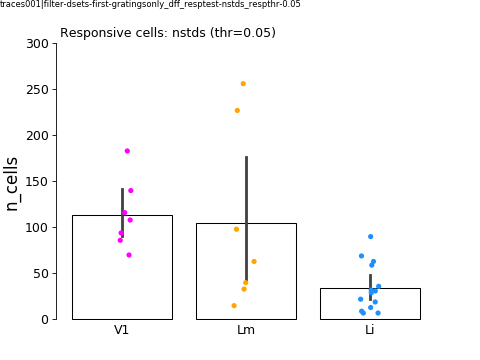

gratings_ncells_responsive_by_fov_dff_resptest-nstds_respthr-0.05


In [905]:
fig, ax = pl.subplots()
sns.barplot(x='visual_area',y='n_cells', data=cellcounts, ax=ax,
           palette=area_colors, order=visual_areas, edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,1))
sns.stripplot(x='visual_area',y='n_cells', data=cellcounts, ax=ax,
           palette=area_colors, order=visual_areas)
ax.tick_params(axis='x', which='both', size=0)
ax.set_xlabel('')
ax.set_ylim([-1, 300])
sns.despine(trim=True, offset=4, bottom=True)

putils.label_figure(fig, data_id)

ax.set_title("Responsive cells: %s (thr=%.2f)" % (responsive_test, responsive_thr), 
            loc='left', fontsize=12)

figname = '%s_ncells_responsive_by_fov_%s' % (experiment, response_str)

pl.savefig(os.path.join(aggregate_dir, 'responsivity', responsive_test, '%.svg' % figname))
print(figname)

# filter

In [906]:
min_ncells=30 # 50
few_cells = []
for datakey, f in MEANS.items():
    print(datakey, f.shape)
    if f.shape[1] < min_ncells:
        few_cells.append(datakey)


('20190512_JC083_fov1', (800, 256))
('20190603_JC080_fov1', (1280, 98))
('20190527_JC092_fov3', (320, 19))
('20190609_JC099_fov1', (1280, 9))
('20191111_JC120_fov1', (1280, 7))
('20190517_JC083_fov1', (1279, 15))
('20190522_JC089_fov1', (623, 22))
('20190613_JC097_fov1', (1280, 70))
('20191018_JC113_fov1', (1280, 36))
('20190622_JC085_fov1', (1280, 108))
('20191008_JC091_fov1', (1400, 59))
('20190606_JC091_fov1', (1280, 32))
('20190605_JC090_fov1', (1280, 31))
('20191105_JC117_fov1', (640, 7))
('20190618_JC097_fov1', (1280, 33))
('20190602_JC091_fov1', (1280, 90))
('20190614_JC091_fov1', (1280, 63))
('20190616_JC097_fov1', (1280, 183))
('20190612_JC099_fov1', (1280, 29))
('20190617_JC097_fov1', (1280, 86))
('20190511_JC083_fov1', (800, 140))
('20191006_JC110_fov1', (1280, 94))
('20190525_JC084_fov1', (1280, 63))
('20190607_JC091_fov1', (1280, 69))
('20190522_JC084_fov1', (1240, 116))
('20190617_JC099_fov1', (1280, 13))
('20190627_JC091_fov1', (1280, 40))
('20190513_JC078_fov1', (960, 2

In [907]:
few_cells

['20190527_JC092_fov3',
 '20190609_JC099_fov1',
 '20191111_JC120_fov1',
 '20190517_JC083_fov1',
 '20190522_JC089_fov1',
 '20191105_JC117_fov1',
 '20190612_JC099_fov1',
 '20190617_JC099_fov1']

In [908]:
response_str

'dff_resptest-nstds_respthr-0.05'

In [909]:
excl = copy.copy(few_cells)
bad_targeting = ['20190605_JC090_fov1', '20191008_JC091_fov1', '20190627_JC091_fov1']
funky = ['20191105_JC117_fov1']
excl.extend(bad_targeting)
excl.extend(funky)
excl = np.unique(excl)

In [910]:
excl

array(['20190517_JC083_fov1', '20190522_JC089_fov1', '20190527_JC092_fov3',
       '20190605_JC090_fov1', '20190609_JC099_fov1', '20190612_JC099_fov1',
       '20190617_JC099_fov1', '20190627_JC091_fov1', '20191008_JC091_fov1',
       '20191105_JC117_fov1', '20191111_JC120_fov1'],
      dtype='|S19')

# Output dir

In [911]:
correlations_dir = os.path.join(aggregate_dir, 'correlations','%s_%s_%s' % (experiment, response_type, responsive_test) )
if not os.path.exists(correlations_dir):
    os.makedirs(correlations_dir)


In [912]:
correlations_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/gratings_dff_nstds'

# Signal correlations
Index of similarity b w pairs of neurons in mean response to different stimulus types.

In [913]:
animalid = 'JC084'
session = '20190522'
fovnum = 1
datakey = '%s_%s_fov%i' % (session, animalid, fovnum)

if experiment == 'blobs':
    obj = util.Objects(animalid, session, 'FOV%i_zoom2p0x' %  fovnum, traceid=traceid)
else:
    obj = util.Gratings(animalid, session, 'FOV%i_zoom2p0x' %  fovnum, traceid=traceid)
sdf = obj.get_stimuli()


Creating gratings object [JC084|20190522|FOV1_zoom2p0x|traces001]
... getting stimulus info for: combined_gratings_static


In [914]:
curr_datakeys = [k for k in full_datakeys if k not in excl]
curr_sdata = sdata_exp[sdata_exp['datakey'].isin(curr_datakeys)].copy()
print(len(curr_datakeys), len(full_datakeys))

(15, 22)


In [965]:
include_stimuli='images'

all_configs = ['config%03d' % i for i in np.arange(1, sdf.shape[0]+1)]
if experiment=='blobs':
    control_configs = ['config001', 'config002', 'config003', 'config004', 'config005']
elif experiment=='gratings':
    control_configs = sdf[sdf['size']>100].index.tolist()
    
if include_stimuli=='fullscreen':
    included_configs = [c for c in all_configs if c in control_configs]
elif include_stimuli=='image':
    included_configs = [c for c in all_configs if c not in control_configs]
elif include_stimuli=='all':
    included_configs = all_configs
else:
    print("UNKNOWN: %s" % include_stimuli)
print("Restricting stimuli to: %s (%i conditions)" % (include_stimuli, len(included_configs)))

UNKNOWN: images
Restricting stimuli to: images (32 conditions)


In [966]:
x_list = []
for (visual_area, animalid, session, fovnum), g in curr_sdata.groupby(['visual_area', 'animalid', 'session', 'fovnum']):

    datakey = '_'.join([session, animalid, 'fov%i' % fovnum])
    if datakey not in MEANS.keys():
        print('... missing %s' % datakey)
        continue
    trial_means = MEANS[datakey].copy() # shape: (ntrials_total, nrois_total)
    if response_type == 'corrected':
        cfg_tmp = trial_means['config']
        trial_means = putils.zscore_dataframe(trial_means)
        trial_means['config'] = cfg_tmp
        
    tuning_ = trial_means[trial_means['config'].isin(included_configs)].groupby(['config']).mean().reset_index()
    cc = putils.melt_square_matrix(tuning_.corr(), metric_name='corrcoef', include_diagonal=False)
    
    metadict={'visual_area': visual_area, 'animalid': animalid, 
              'session': session, 'fovnum': fovnum, 'datakey': datakey}
    cc = putils.add_meta_to_df(cc, metadict)
    x_list.append(cc)

signal_corrs = pd.concat(x_list, axis=0).reset_index(drop=True)

# Get mean across animals
mean_signal_corrs = signal_corrs.groupby(['visual_area', 'datakey']).mean().reset_index()

# Noise correlations
#### Similarity in trial-by-trial repsonse variability between neurons
Calculate response vector for each stimulus type (each element in vector is reposnse to trial i of stimulus cond)
Take mean noise corr. over all stimulus types

In [967]:
x_list = []
for (visual_area, animalid, session, fovnum), g in curr_sdata.groupby(['visual_area', 'animalid', 'session', 'fovnum']):
    datakey = '_'.join([session, animalid, 'fov%i' % fovnum])
    if datakey not in MEANS.keys():
        print("[%s] skipping %s" % (visual_area, datakey))
        continue

    trial_means = MEANS[datakey] # shape: (ntrials_total, nrois_total)
    if response_type == 'corrected':
        cfg_tmp = trial_means['config']
        trial_means = putils.zscore_dataframe(trial_means)
        trial_means['config'] = cfg_tmp
    
    # mean-subtract
    rlist = [r for r in trial_means.columns if putils.isnumber(r)]
    tmeans = pd.concat([pd.concat([cdf[rlist] - cdf[rlist].mean(), cdf['config']], axis=1) \
                            for cfg, cdf in trial_means.groupby(['config'])]).reset_index(drop=True)

    
    # Calculate noise corr: ncorrs[(ncorrs['row']==0) & (ncorrs['col']==1)] # noise corrs, all conditions for neuron i, j (i=0, j=1)
    ncorrs = pd.concat([putils.melt_square_matrix(resp.corr(), metric_name='corrcoef', 
                                           add_values={'config': cfg}, include_diagonal=False) 
                        for cfg, resp in tmeans[tmeans['config'].isin(included_configs)].groupby(['config'])], axis=0)
    # Get mean noise corr over all stim conds for each pair
    cc = ncorrs.groupby(['row', 'col']).mean().reset_index()
    metadict={'visual_area': visual_area, 'animalid': animalid, 
              'session': session, 'fovnum': fovnum, 'datakey': datakey}
    cc = putils.add_meta_to_df(cc, metadict)
    x_list.append(cc)
noise_corrs = pd.concat(x_list, axis=0).reset_index(drop=True)

# Get mean across animals
mean_noise_corrs = noise_corrs.groupby(['visual_area', 'datakey']).mean().reset_index()

In [968]:
filter_str

'filter-dsets-first-gratingsonly_dff_resptest-nstds_respthr-0.05'

<IPython.core.display.Javascript object>


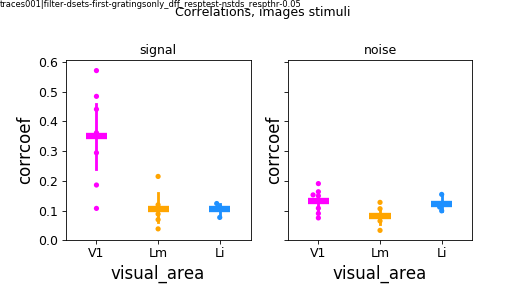

gratings_images_signal_and_noise_correlations_min30__filter-dsets-first-gratingsonly_dff_resptest-nstds_respthr-0.05


In [969]:
fig, axn = pl.subplots(1, 2, sharex=True, sharey=True, figsize=(7,4))
ax = axn[0]
sns.swarmplot(x='visual_area', y='corrcoef', data=mean_signal_corrs, ax=ax,
             order=visual_areas, palette=area_colors)
sns.pointplot(x='visual_area', y='corrcoef', data=mean_signal_corrs, ax=ax,
             palette=area_colors, order=visual_areas, join=False, markers='_', scale=3)
ax.set_title('signal')

ax = axn[1]
sns.swarmplot(x='visual_area', y='corrcoef', data=mean_noise_corrs, ax=ax,
             order=visual_areas, palette=area_colors)
sns.pointplot(x='visual_area', y='corrcoef', data=mean_noise_corrs, ax=ax,
             palette=area_colors, order=visual_areas, join=False, markers='_', scale=3)
ax.set_title('noise')
pl.subplots_adjust(bottom=0.2, top=0.8)
fig.suptitle('Correlations, %s stimuli' % include_stimuli)

putils.label_figure(fig, data_id)
figname = '%s_%s_signal_and_noise_correlations_min%i__%s' % (experiment, include_stimuli, min_ncells, filter_str)
pl.savefig(os.path.join(correlations_dir, '%s_zs-ms.svg' % figname))
print(figname)

In [970]:
correlations_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/gratings_dff_nstds'

## ... by distance

#### Assign spatial distance to all pairs in correlation dataframes

In [971]:
datakeys = signal_corrs['datakey'].unique()
roipos = roi_positions[roi_positions['datakey'].isin(datakeys)]
len(datakeys)

15

In [972]:
signal_corrs['distance'] = ''
noise_corrs['distance'] = ''

for di, (datakey, curr_ccs) in enumerate(signal_corrs.groupby(['datakey'])):
    if di%5==0:
        print('%i of %i dsets' % (int(di+1), len(datakeys)))

    curr_rids = sorted(np.union1d(curr_ccs['row'].unique(), curr_ccs['col'].unique()))

    # Coords of cell1 in pair, in order
    coords1 = np.array(roipos[roipos['datakey']==datakey].loc[curr_ccs['row'].values][['ml_pos', 'ap_pos']])
    # Coords of cell2 in pair 
    coords2 = np.array(roipos[roipos['datakey']==datakey].loc[curr_ccs['col'].values][['ml_pos', 'ap_pos']])

    # get dists, in order of appearance
    dists = [np.linalg.norm(c1-c2) for c1, c2 in zip(coords1, coords2)]
    #combined = pd.merge(curr_ccs.reset_index(drop=True), d_df)
    
    signal_corrs['distance'][curr_ccs.index] = dists #d_df['distance'].values
    noise_corrs['distance'][curr_ccs.index] = dists #d_df['distance'].values


1 of 15 dsets
6 of 15 dsets
11 of 15 dsets


In [973]:
incl = [d for d in datakeys if d not in excl]
print("Including %i of %i datakeys" % (len(incl), len(datakeys)))
print("Excluded:", excl)

Including 15 of 15 datakeys
('Excluded:', array(['20190517_JC083_fov1', '20190522_JC089_fov1', '20190527_JC092_fov3',
       '20190605_JC090_fov1', '20190609_JC099_fov1', '20190612_JC099_fov1',
       '20190617_JC099_fov1', '20190627_JC091_fov1', '20191008_JC091_fov1',
       '20191105_JC117_fov1', '20191111_JC120_fov1'],
      dtype='|S19'))


In [974]:
[i for i in datakeys if i not in incl]

[]

#### Plot signal corrs v distance

In [975]:
n_bins = 10
use_quartile=True

if use_quartile:
    signal_corrs['binned_dist'] = pd.qcut(signal_corrs['distance'], n_bins, labels=False)
    noise_corrs['binned_dist'] = pd.qcut(noise_corrs['distance'], n_bins, labels=False)
else:
    signal_corrs['binned_dist'] = pd.cut(signal_corrs['distance'], n_bins, labels=False)
    noise_corrs['binned_dist'] = pd.cut(noise_corrs['distance'], n_bins, labels=False)

#_, bin_sizes = pd.qcut(tuning_corrcoefs['distance'], n_bins, retbins=True)
#bin_edges = bin_sizes[0:-1]


In [976]:
params = ['corrcoef', 'distance', 'binned_dist']
for p in params:
    signal_corrs[p] = signal_corrs[p].astype(float)
    noise_corrs[p] = noise_corrs[p].astype(float)

<IPython.core.display.Javascript object>


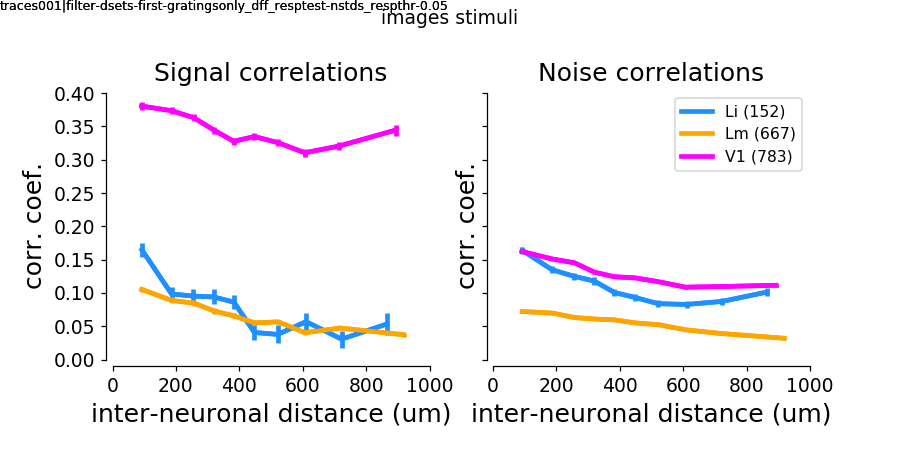

gratings_images_corrcoef_x_dist_bin-eqnum_min30__filter-dsets-first-gratingsonly_dff_resptest-nstds_respthr-0.05


In [977]:
use_std = False

bin_type = 'eqwidth' if not use_quartile else 'eqnum'

fig, axn = pl.subplots(1, 2, figsize=(8,4), sharex=True, sharey=True, dpi=dpi)
ax = axn[0]
plotdf = signal_corrs[signal_corrs['datakey'].isin(incl)].copy()
fig_title = 'Signal correlations'
for visual_area, currdf in plotdf.groupby(['visual_area']):

    ncells_t = sum([len(g['row'].unique()) for dk, g in currdf.groupby(['datakey'])])
    bin_dists = [b_df['distance'].mean() for b, b_df in currdf.groupby(['binned_dist'])]    
    bin_ccs = [b_df['corrcoef'].mean() for b, b_df in currdf.groupby(['binned_dist'])]    
    bin_sems = [spstats.sem(b_df['corrcoef']) for b, b_df in currdf.groupby(['binned_dist'])]    
    bin_stds = [b_df['corrcoef'].std() for b, b_df in currdf.groupby(['binned_dist'])]    
    bin_errs = bin_stds if use_std else bin_sems

    ax.plot(bin_dists, bin_ccs, color=area_colors[visual_area], 
           label='%s (%i)' % (visual_area, ncells_t), lw=3)
    ax.errorbar(bin_dists, bin_ccs, yerr=bin_errs, color=area_colors[visual_area], lw=3)
#ax.legend(bbox_to_anchor=(1., 1))
ax.set_title(fig_title, fontsize=16)

ax = axn[1]
plotdf = noise_corrs[noise_corrs['datakey'].isin(incl)].copy()
fig_title = 'Noise correlations'   
for visual_area, currdf in plotdf.groupby(['visual_area']):

    ncells_t = sum([len(g['row'].unique()) for dk, g in currdf.groupby(['datakey'])])
    bin_dists = [b_df['distance'].mean() for b, b_df in currdf.groupby(['binned_dist'])]    
    bin_ccs = [b_df['corrcoef'].mean() for b, b_df in currdf.groupby(['binned_dist'])]    
    bin_sems = [spstats.sem(b_df['corrcoef']) for b, b_df in currdf.groupby(['binned_dist'])]    
    bin_stds = [b_df['corrcoef'].std() for b, b_df in currdf.groupby(['binned_dist'])]    
    bin_errs = bin_stds if use_std else bin_sems

    ax.plot(bin_dists, bin_ccs, color=area_colors[visual_area], 
           label='%s (%i)' % (visual_area, ncells_t), lw=3)
    ax.errorbar(bin_dists, bin_ccs, yerr=bin_errs, color=area_colors[visual_area], lw=3)
    ax.set_xlabel('inter-neuronal distance (um)')
    ax.set_ylabel('corr. coef.')

ax.legend(bbox_to_anchor=(1., 1))
ax.set_title(fig_title, fontsize=16)
ymax = 1000 if use_quartile else 1300
for ax in axn:
    #ax.set_ylim([0, 0.4])
    xticks = np.linspace(0, ymax, 6)
    ax.set_xticks(xticks)
    ax.set_xticklabels([int(b) for b in xticks])
    ax.set_xlabel('inter-neuronal distance (um)')
    ax.set_ylabel('corr. coef.')
    sns.despine(trim=True, offset=4, ax=ax)
putils.label_figure(fig, data_id)
pl.subplots_adjust(bottom=0.2, top=0.8)

pl.suptitle("%s stimuli" % include_stimuli)
putils.label_figure(fig, data_id)
figname = '%s_%s_corrcoef_x_dist_bin-%s_min%i__%s' % (experiment, include_stimuli, bin_type, min_ncells, filter_str)
pl.savefig(os.path.join(correlations_dir, '%s_zs-ms.svg' % figname))
print(figname)

## Average over FOVS

<IPython.core.display.Javascript object>


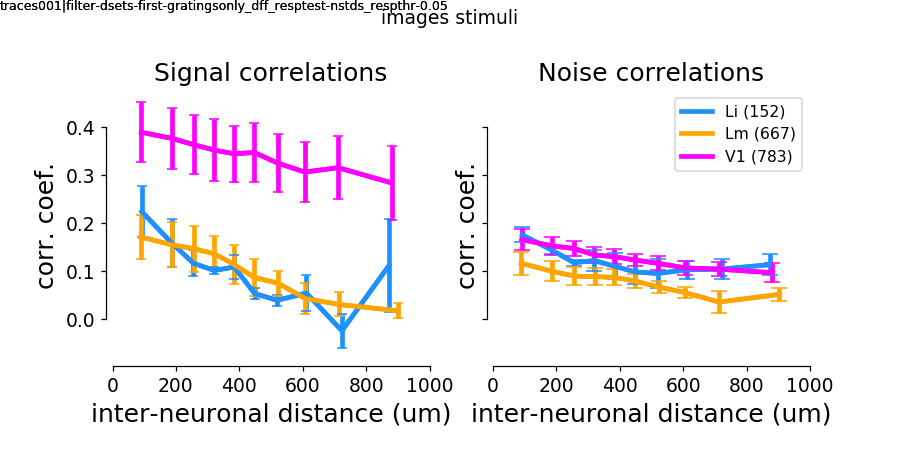

gratings_images_corrcoef_x_dist_avg-datasets_bin-eqnum_min30cells__filter-dsets-first-gratingsonly_dff_resptest-nstds_respthr-0.05


In [988]:
use_std = False


fig, axn = pl.subplots(1, 2, figsize=(8,4), sharex=True, sharey=True, dpi=dpi)
ax = axn[0]
plotdf = signal_corrs[signal_corrs['datakey'].isin(incl)].copy()
fig_title = 'Signal correlations'
for visual_area, currdf in plotdf.groupby(['visual_area']):

    ncells_t = sum([len(g['row'].unique()) for dk, g in currdf.groupby(['datakey'])])
    bin_dists = [b_df.groupby(['datakey'])['distance'].mean().mean() for b, b_df in currdf.groupby(['binned_dist'])]
    bin_ccs = [b_df.groupby(['datakey'])['corrcoef'].mean().mean() for b, b_df in currdf.groupby(['binned_dist'])]
    bin_sems = [spstats.sem(b_df.groupby(['datakey'])['corrcoef'].mean()) for b, b_df in currdf.groupby(['binned_dist'])]
    bin_stds = [b_df.groupby(['datakey'])['corrcoef'].mean().std() for b, b_df in currdf.groupby(['binned_dist'])]
    bin_errs = bin_stds if use_std else bin_sems
    
    ax.plot(bin_dists, bin_ccs, color=area_colors[visual_area], 
           label='%s (%i)' % (visual_area, ncells_t), lw=3)
    ax.errorbar(bin_dists, bin_ccs, yerr=bin_errs, color=area_colors[visual_area], lw=3, capsize=3)
#ax.legend(bbox_to_anchor=(1., 1))
ax.set_title(fig_title, fontsize=16)

ax = axn[1]
plotdf = noise_corrs[noise_corrs['datakey'].isin(incl)].copy()
fig_title = 'Noise correlations'   
for visual_area, currdf in plotdf.groupby(['visual_area']):

    ncells_t = sum([len(g['row'].unique()) for dk, g in currdf.groupby(['datakey'])])
    bin_dists = [b_df.groupby(['datakey'])['distance'].mean().mean() for b, b_df in currdf.groupby(['binned_dist'])]
    bin_ccs = [b_df.groupby(['datakey'])['corrcoef'].mean().mean() for b, b_df in currdf.groupby(['binned_dist'])]
    bin_sems = [spstats.sem(b_df.groupby(['datakey'])['corrcoef'].mean()) for b, b_df in currdf.groupby(['binned_dist'])]
    bin_stds = [b_df.groupby(['datakey'])['corrcoef'].mean().std() for b, b_df in currdf.groupby(['binned_dist'])]
    bin_errs = bin_stds if use_std else bin_sems

    ax.plot(bin_dists, bin_ccs, color=area_colors[visual_area], 
           label='%s (%i)' % (visual_area, ncells_t), lw=3)
    ax.errorbar(bin_dists, bin_ccs, yerr=bin_errs, color=area_colors[visual_area], lw=3, capsize=5)
    ax.set_xlabel('inter-neuronal distance (um)')
    ax.set_ylabel('corr. coef.')

ax.legend(bbox_to_anchor=(1., 1))
ax.set_title(fig_title, fontsize=16)
ymax = 1000 if use_quartile else 1300
for ax in axn:
    xticks = np.linspace(0, ymax, 6)
    ax.set_xticks(xticks)
    ax.set_xticklabels([int(b) for b in xticks])
    ax.set_xlabel('inter-neuronal distance (um)')
    ax.set_ylabel('corr. coef.')
    sns.despine(trim=True, offset=4, ax=ax)
pl.subplots_adjust(bottom=0.2, top=0.8)
putils.label_figure(fig, data_id)

pl.suptitle("%s stimuli" % include_stimuli)
putils.label_figure(fig, data_id)
figname = '%s_%s_corrcoef_x_dist_avg-datasets_bin-%s_min%icells__%s' % (experiment, include_stimuli, bin_type, min_ncells, filter_str)
pl.savefig(os.path.join(correlations_dir, '%s_zs-ms.svg' % figname))
print(figname)

## Split FOVs

<IPython.core.display.Javascript object>


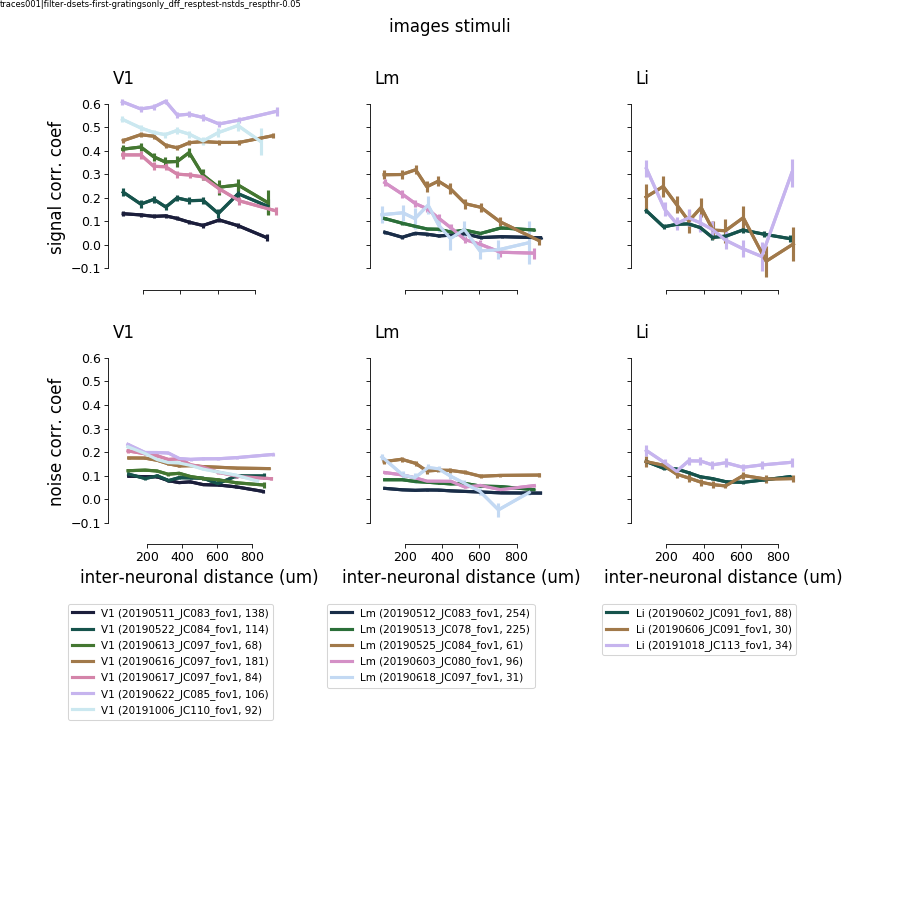

gratings_images_corrcoef_x_distance_split-datasets_bin-eqnum__filter-dsets-first-gratingsonly_dff_resptest-nstds_respthr-0.05


In [979]:

fig, axn = pl.subplots(2, 3, figsize=(12,12), sharex=True, sharey=True) #, dpi=dpi)
plotdf = signal_corrs[signal_corrs['datakey'].isin(incl)].copy()
#fig_title = 'Signal correlations'
#fig, axn = pl.subplots(1, 3, figsize=(15,8), sharex=True, sharey=True)
for ax, (visual_area, currdf) in zip(axn.flat[0:3][::-1], plotdf.groupby(['visual_area'])):
    dcolors = sns.color_palette('cubehelix', n_colors=len(currdf['datakey'].unique()))
    for dcolor, (dkey, g) in zip(dcolors, currdf.groupby(['datakey'])):

        ncells_t = sum([len(g['row'].unique())]) # for dk, g in currdf.groupby(['datakey'])])
        bin_dists = [b_df['distance'].mean() for b, b_df in g.groupby(['binned_dist'])]  
        bin_ccs = [b_df['corrcoef'].mean() for b, b_df in g.groupby(['binned_dist'])]
        bin_sems = [spstats.sem(b_df['corrcoef']) for b, b_df in g.groupby(['binned_dist'])]    

        ax.plot(bin_dists, bin_ccs, color=dcolor, 
               label='%s (%s, %i)' % (visual_area, dkey, ncells_t), lw=3)
        ax.errorbar(bin_dists, bin_ccs, yerr=bin_sems, color=dcolor, lw=3)
        #ax.set_xlabel('inter-neuronal distance (um)')
    #ax.set_ylim([-0.6, 0.8])
    ax.set_ylabel('')
    ax.set_xticks(np.linspace(0, 1000, 6))
    #sns.despine(trim=True, offset=4, ax=ax)
    #ax.legend(bbox_to_anchor=(0.9, -0.3)) #1))
    ax.set_title(visual_area, loc='left', fontsize=16)
axn[0,0].set_ylabel('signal corr. coef')

# Noise corrs
plotdf = noise_corrs[noise_corrs['datakey'].isin(incl)].copy()
for ax, (visual_area, currdf) in zip(axn.flat[3:6][::-1], plotdf.groupby(['visual_area'])):
    dcolors = sns.color_palette('cubehelix', n_colors=len(currdf['datakey'].unique()))
    for dcolor, (dkey, g) in zip(dcolors, currdf.groupby(['datakey'])):

        ncells_t = sum([len(g['row'].unique())]) # for dk, g in currdf.groupby(['datakey'])])
        bin_dists = [b_df['distance'].mean() for b, b_df in g.groupby(['binned_dist'])]  
        bin_ccs = [b_df['corrcoef'].mean() for b, b_df in g.groupby(['binned_dist'])]
        bin_sems = [spstats.sem(b_df['corrcoef']) for b, b_df in g.groupby(['binned_dist'])]    

        ax.plot(bin_dists, bin_ccs, color=dcolor, 
               label='%s (%s, %i)' % (visual_area, dkey, ncells_t), lw=3)
        ax.errorbar(bin_dists, bin_ccs, yerr=bin_sems, color=dcolor, lw=3)
        ax.set_xlabel('inter-neuronal distance (um)')
    #ax.set_ylim([0, 0.06])
    #ax.set_ylim([-0.2, 0.5])
    ax.set_ylabel('')
    ax.legend(bbox_to_anchor=(0.95, -0.3)) #1))
    ax.set_title(visual_area, loc='left', fontsize=16)
    ax.set_xticks(np.linspace(0, 1000, 6))
axn[1,0].set_ylabel('noise corr. coef')

for ax in axn.flat:
    sns.despine(trim=True, offset=4, ax=ax)

pl.suptitle('%s stimuli' % include_stimuli, fontsize=16)
pl.subplots_adjust(wspace=0.5, hspace=0.3, bottom=0.4, top=0.9)


putils.label_figure(fig, data_id)
figname = '%s_%s_corrcoef_x_distance_split-datasets_bin-%s__%s' % (experiment, include_stimuli, bin_type, filter_str)
pl.savefig(os.path.join(correlations_dir, '%s.svg' % figname))
print(figname)

In [929]:
correlations_dir
#

'/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/gratings_dff_nstds'

# What are the RF properties of highly correlated cells?

# Corr s a function of distance, along Azimuth vs along Elev


# Calculate variability (non-scaled fano factor)
#### Fano = (std**2 x c**2)/(mean*c).  
This only works if c=1 (scaling of F.R.), since larger F.R. disproportionally affects variance than mean 
#### Adjusted fano = (std_x**2/std_y**2) / (mean_x**2/mean_y**2), 
where we express mean and variance in terms of fractional changes in activity and variability from y to x.

# Variance

In [980]:
use_relative=True

# rel_str='REL_' if use_relative else ''
rel_var_=None; rel_mean_=None;

x_list = []
for (visual_area, animalid, session, fovnum), g in curr_sdata.groupby(['visual_area', 'animalid', 'session', 'fovnum']):

    datakey = '_'.join([session, animalid, 'fov%i' % fovnum])
    if datakey not in MEANS.keys():
        print("[%s] skipping %s" % (visual_area, datakey))
        continue

    trial_means = MEANS[datakey].copy() # shape: (ntrials_total, nrois_total)
    if response_type == 'corrected':
        cfg_tmp = trial_means['config']
        trial_means = putils.zscore_dataframe(trial_means)
        trial_means['config'] = cfg_tmp
    tmeans = trial_means[trial_means['config'].isin(included_configs)]  
    mean_ = means_x_reps.unstack().reset_index().rename(columns={0: 'mean', 'level_0': 'rid'}).reset_index(drop=True)

    # Get mean and variance (within condition)
    means_x_reps = tmeans.groupby(['config']).mean()
    variance_x_reps = tmeans.groupby(['config']).apply(np.var)
    var_ = variance_x_reps.unstack().reset_index().rename(columns={0: 'variance', 'level_0': 'rid'}).reset_index(drop=True)
    vardf = pd.merge(mean_, var_)
    
    if use_relative:
        trial_bas = BAS[datakey].copy()
        if response_type == 'corrected':
            cfg_tmp = trial_bas['config']
            trial_bas = putils.zscore_dataframe(trial_bas)
            trial_bas['config'] = cfg_tmp
        tbas = trial_bas[trial_bas['config'].isin(included_configs)]
        
        variance_x_reps_bas = tbas.groupby(['config']).apply(np.var) # (trial_bas.groupby(['config']).std()**2.) 
        relative_var = variance_x_reps.divide(variance_x_reps_bas)
        rel_var_ = relative_var.unstack().reset_index().rename(columns={0: 'r_variance', 'level_0': 'rid'}).reset_index(drop=True)

        means_x_reps_bas = tbas.groupby(['config']).mean()
        relative_mean = means_x_reps.divide(means_x_reps_bas)    
        rel_mean_ = relative_mean.unstack().reset_index().rename(columns={0: 'r_mean', 'level_0': 'rid'}).reset_index(drop=True)
    
    if rel_var_ is not None and rel_mean_ is not None:
        reldf = pd.merge(rel_mean_, rel_var_)
        vdf = pd.merge(vardf, reldf)
    else:
        vdf = vardf.copy()
    
    metadict={'visual_area': visual_area, 'animalid': animalid, 
              'session': session, 'fovnum': fovnum, 'datakey': datakey}
    cc = putils.add_meta_to_df(vdf, metadict)
    x_list.append(cc)

variance = pd.concat(x_list, axis=0).reset_index(drop=True)

------- mean values ----------
  visual_area         rid      mean  variance        r_mean    r_variance  \
0          Li   94.814815  0.017236  0.004961  6.736385e+15  3.582803e+29   
1          Lm  110.398668  0.014758  0.003488  3.787559e+14  2.368110e+29   
2          V1   97.945241  0.017960  0.002522  3.768250e+14  1.704318e+29   

   fovnum  
0     1.0  
1     1.0  
2     1.0  


<IPython.core.display.Javascript object>


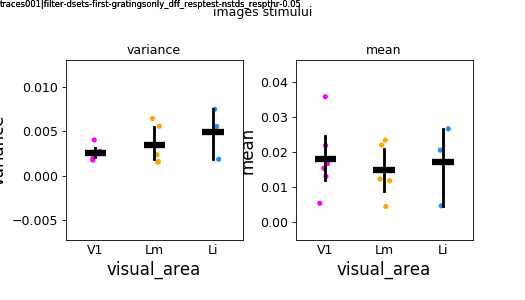

--- STATS (variance): 
[('V1', 'Lm')] p=0.551 (holm), reject H0=False
[('V1', 'Li')] p=0.543 (holm), reject H0=False
[('Lm', 'Li')] p=0.551 (holm), reject H0=False
--- STATS (mean): 
[('V1', 'Lm')] p=0.939 (holm), reject H0=False
[('V1', 'Li')] p=0.939 (holm), reject H0=False
[('Lm', 'Li')] p=0.939 (holm), reject H0=False
gratings_images_variance_and_mean_byfov__filter-dsets-first-gratingsonly_dff_resptest-nstds_respthr-0.05


In [981]:
average_fovs = True
multi_comp_test = 'holm'


data_type = 'allcells' if not average_fovs else 'byfov'
plotdf = variance[variance['datakey'].isin(incl)].copy()
datadf = plotdf.groupby(['visual_area', 'datakey']).mean().reset_index() if average_fovs else plotdf.copy()

print("------- mean values ----------")
print(datadf.groupby(['visual_area']).mean().reset_index())

fig, axn = pl.subplots(1, 2, sharex=True, sharey=False, figsize=(7,4))

metric = 'variance'
ax = axn[0]
ax.set_title(metric)
sns.stripplot(x='visual_area', y=metric, data=datadf, ax=ax,
             order=visual_areas, palette=area_colors, zorder=1, alpha=1)
sns.pointplot(x='visual_area', y=metric, data=datadf, ax=ax,
             order=visual_areas, join=False, color='k', zorder=0, markers='_', scale=3)
ax.tick_params(axis='x', which='both', size=0)
print('--- STATS (%s): ' % metric) 
aggr.do_mannwhitney(datadf, metric=metric, multi_comp_test=multi_comp_test)

metric = 'mean'
ax = axn[1]
ax.set_title(metric)
sns.stripplot(x='visual_area', y=metric, data=datadf, ax=ax,
             order=visual_areas, palette=area_colors, zorder=1, alpha=1)
sns.pointplot(x='visual_area', y=metric, data=datadf, ax=ax,
             order=visual_areas, join=False, color='k', zorder=0, markers='_', scale=3)
#sns.despine(bottom=True, trim=True, ax=ax)
ax.tick_params(axis='x', which='both', size=0)
print('--- STATS (%s): ' % metric) 
aggr.do_mannwhitney(datadf, metric=metric, multi_comp_test=multi_comp_test)

pl.subplots_adjust(bottom=0.2, top=0.8, wspace=0.3)

putils.label_figure(fig, data_id)
fig.suptitle('%s stimului' % include_stimuli)

putils.label_figure(fig, data_id)
figname = '%s_%s_variance_and_mean_%s__%s' % (experiment, include_stimuli, data_type, filter_str)
pl.savefig(os.path.join(correlations_dir, '%s.svg' % figname))
print(figname)

### barplots

------- mean values ----------
  visual_area         rid      mean  variance        r_mean    r_variance  \
0          Li   99.750000  0.011445  0.005726  2.244719e+15  3.883185e+29   
1          Lm  114.672241  0.016058  0.003801  2.478271e+14  2.489779e+29   
2          V1  105.069162  0.016472  0.002528  3.601026e+14  1.742362e+29   

   fovnum  
0     1.0  
1     1.0  
2     1.0  


<IPython.core.display.Javascript object>


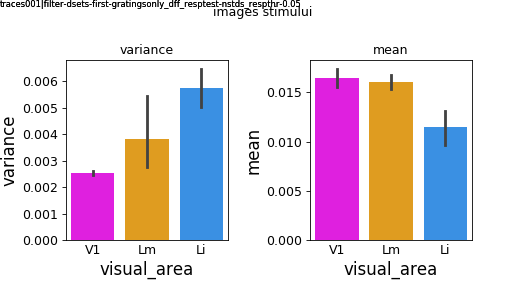

STATS (variance): 
[('V1', 'Lm')] p=0.181 (holm), reject H0=False
[('V1', 'Li')] p=0.000 (holm), reject H0=True
[('Lm', 'Li')] p=0.000 (holm), reject H0=True
STATS (mean): 
[('V1', 'Lm')] p=0.000 (holm), reject H0=True
[('V1', 'Li')] p=0.267 (holm), reject H0=False
[('Lm', 'Li')] p=0.017 (holm), reject H0=True
gratings_images_allcells_var_and_mean_bar__filter-dsets-first-gratingsonly_dff_resptest-nstds_respthr-0.05


In [982]:
average_fovs = False


multi_comp_test = 'holm'
data_type = 'allcells' if not average_fovs else 'byfov'
datadf = plotdf.groupby(['visual_area', 'datakey']).mean().reset_index() if average_fovs else plotdf.copy()

print("------- mean values ----------")
print(datadf.groupby(['visual_area']).mean().reset_index())


fig, axn = pl.subplots(1, 2, sharex=True, sharey=False, figsize=(7,4))
metric = 'variance'
ax = axn[0]
ax.set_title(metric)
sns.barplot(x='visual_area', y=metric, data=datadf, ax=ax,
             order=visual_areas, palette=area_colors)
ax.tick_params(axis='x', which='both', size=0)
print('STATS (%s): ' % metric) 
aggr.do_mannwhitney(datadf, metric=metric, multi_comp_test=multi_comp_test)

metric = 'mean'
ax = axn[1]
ax.set_title(metric)
sns.barplot(x='visual_area', y=metric, data=datadf, ax=ax,
             order=visual_areas, palette=area_colors)
#sns.despine(bottom=True, trim=True, ax=ax)
ax.tick_params(axis='x', which='both', size=0)
print('STATS (%s): ' % metric) 
aggr.do_mannwhitney(datadf, metric=metric, multi_comp_test=multi_comp_test)


pl.subplots_adjust(bottom=0.2, top=0.8, wspace=0.5)
putils.label_figure(fig, data_id)
fig.suptitle('%s stimului' % include_stimuli)

putils.label_figure(fig, data_id)
figname = '%s_%s_%s_var_and_mean_bar__%s' % (experiment, include_stimuli, data_type, filter_str)
pl.savefig(os.path.join(correlations_dir, '%s.svg' % figname))
print(figname)

## Fano?

In [983]:
plotdf['r_fano'] = plotdf['r_variance']/plotdf['r_mean']
plotdf['fano'] = plotdf['variance']/plotdf['mean']


------- mean values ----------
  visual_area         rid      mean  variance        r_mean    r_variance  \
0          Li   94.814815  0.017236  0.004961  6.736385e+15  3.582803e+29   
1          Lm  110.398668  0.014758  0.003488  3.787559e+14  2.368110e+29   
2          V1   97.945241  0.017960  0.002522  3.768250e+14  1.704318e+29   

   fovnum        r_fano      fano  
0     1.0  2.172918e+14  0.482497  
1     1.0  2.186490e+13  0.104552  
2     1.0 -3.630956e+14  0.152906  


<IPython.core.display.Javascript object>


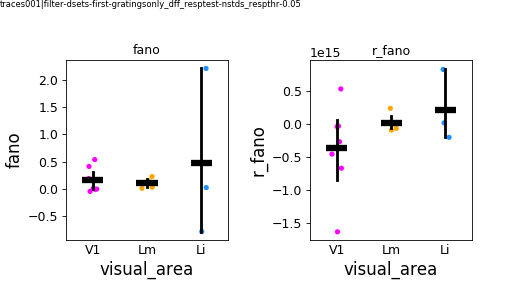

STATS (fano): 
[('V1', 'Lm')] p=0.939 (holm), reject H0=False
[('V1', 'Li')] p=0.939 (holm), reject H0=False
[('Lm', 'Li')] p=0.939 (holm), reject H0=False
STATS (r_fano): 
[('V1', 'Lm')] p=0.257 (holm), reject H0=False
[('V1', 'Li')] p=0.257 (holm), reject H0=False
[('Lm', 'Li')] p=0.500 (holm), reject H0=False
gratings_images_byfov_fano-by-fov__filter-dsets-first-gratingsonly_dff_resptest-nstds_respthr-0.05


In [984]:
average_fovs = True
multi_comp_test = 'holm'


data_type = 'allcells' if not average_fovs else 'byfov'
datadf = plotdf.groupby(['visual_area', 'datakey']).mean().reset_index() if average_fovs else plotdf.copy()

print("------- mean values ----------")
print(datadf.groupby(['visual_area']).mean().reset_index())


fig, axn = pl.subplots(1, 2, sharex=True, sharey=False, figsize=(7,4))
ax = axn[0]
metric = 'fano'
sns.stripplot(x='visual_area', y=metric, data=datadf, ax=ax,
             order=visual_areas, palette=area_colors, zorder=1, alpha=1)
sns.pointplot(x='visual_area', y=metric, data=datadf, ax=ax,
             order=visual_areas, join=False, color='k', zorder=0, markers='_', scale=3)
ax.tick_params(axis='x', which='both', size=0)
print('STATS (%s): ' % metric) 
aggr.do_mannwhitney(datadf, metric=metric, multi_comp_test=multi_comp_test)
ax.set_title(metric)

ax = axn[1]
metric = 'r_fano'
sns.stripplot(x='visual_area', y=metric, data=datadf, ax=ax,
             order=visual_areas, palette=area_colors, zorder=1, alpha=1)
sns.pointplot(x='visual_area', y=metric, data=datadf, ax=ax,
             order=visual_areas, join=False, color='k', zorder=0, markers='_', scale=3)
ax.tick_params(axis='x', which='both', size=0)
print('STATS (%s): ' % metric) 
aggr.do_mannwhitney(datadf, metric=metric, multi_comp_test=multi_comp_test)
ax.set_title(metric)

pl.subplots_adjust(bottom=0.2, top=0.8, wspace=0.5)

putils.label_figure(fig, data_id)
figname = '%s_%s_%s_fano-by-fov__%s' % (experiment, include_stimuli, data_type, filter_str)
pl.savefig(os.path.join(correlations_dir, '%s.svg' % figname))
print(figname)

In [985]:
include_stimuli

'images'

In [986]:
min_ncells

30

------- mean values ----------
  visual_area         rid      mean  variance        r_mean    r_variance  \
0          Li   99.750000  0.011445  0.005726  2.244719e+15  3.883185e+29   
1          Lm  114.672241  0.016058  0.003801  2.478271e+14  2.489779e+29   
2          V1  105.069162  0.016472  0.002528  3.601026e+14  1.742362e+29   

   fovnum        r_fano      fano  
0     1.0  5.051463e+14  0.029316  
1     1.0 -1.471726e+13  0.133691  
2     1.0 -4.016934e+14  0.137578  


<IPython.core.display.Javascript object>


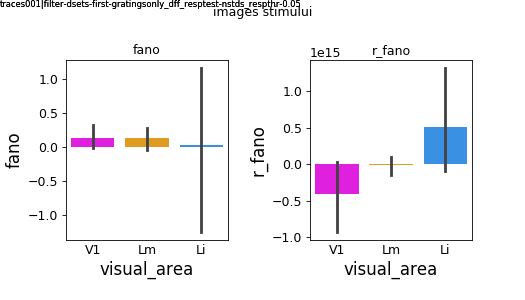

STATS (fano): 
[('V1', 'Lm')] p=0.000 (holm), reject H0=True
[('V1', 'Li')] p=0.000 (holm), reject H0=True
[('Lm', 'Li')] p=0.136 (holm), reject H0=False
STATS (r_fano): 
[('V1', 'Lm')] p=0.084 (holm), reject H0=False
[('V1', 'Li')] p=0.304 (holm), reject H0=False
[('Lm', 'Li')] p=0.142 (holm), reject H0=False
gratings_images_allcells_fano_bar__filter-dsets-first-gratingsonly_dff_resptest-nstds_respthr-0.05


In [987]:
average_fovs = False

multi_comp_test = 'holm'
data_type = 'allcells' if not average_fovs else 'byfov'
datadf = plotdf.groupby(['visual_area', 'datakey']).mean().reset_index() if average_fovs else plotdf.copy()

print("------- mean values ----------")
print(datadf.groupby(['visual_area']).mean().reset_index())


fig, axn = pl.subplots(1, 2, sharex=True, sharey=False, figsize=(7,4))
metric = 'fano'
ax = axn[0]
ax.set_title(metric)
sns.barplot(x='visual_area', y=metric, data=datadf, ax=ax,
             order=visual_areas, palette=area_colors)
ax.tick_params(axis='x', which='both', size=0)
print('STATS (%s): ' % metric) 
aggr.do_mannwhitney(datadf, metric=metric, multi_comp_test=multi_comp_test)

metric = 'r_fano'
ax = axn[1]
ax.set_title(metric)
sns.barplot(x='visual_area', y=metric, data=datadf, ax=ax,
             order=visual_areas, palette=area_colors)
#sns.despine(bottom=True, trim=True, ax=ax)
ax.tick_params(axis='x', which='both', size=0)
print('STATS (%s): ' % metric) 
aggr.do_mannwhitney(datadf, metric=metric, multi_comp_test=multi_comp_test)


pl.subplots_adjust(bottom=0.2, top=0.8, wspace=0.5)
putils.label_figure(fig, data_id)
fig.suptitle('%s stimului' % include_stimuli)



putils.label_figure(fig, data_id)
figname = '%s_%s_%s_fano_bar__%s' % (experiment, include_stimuli, data_type, filter_str)
pl.savefig(os.path.join(correlations_dir, '%s.svg' % figname))
print(figname)

In [811]:
reload(putils)

<module 'pipeline.python.utils' from '/home/julianarhee/Repositories/2p-pipeline/pipeline/python/utils.pyc'>

# Test 1 dataset

In [1379]:
animalid = 'JC084'
session = '20190522'
fovnum = 1


In [1396]:
traces, labels, sdf = aggr.load_traces(animalid, session, fovnum, experiment, traceid=traceid, 
                                       response_type='corrected',
                                      responsive_test=responsive_test, 
                                       responsive_thr=responsive_thr, n_stds=n_stds)
trialmeans = aggr.traces_to_trials(traces, labels, epoch='baseline')


Creating gratings object [JC084|20190522|FOV1_zoom2p0x|traces001]
... exp.load()
... loading saved data array (corrected).


KeyboardInterrupt: 

In [1410]:
trialbas = aggr.traces_to_trials(traces, labels, epoch='baseline')

trialbas = putils.zscore_dataframe(trialbas)



<IPython.core.display.Javascript object>


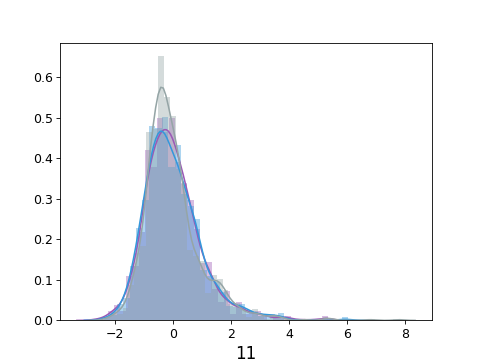

In [1411]:
pl.figure()
sns.distplot(trialbas[1])
sns.distplot(trialbas[239])
sns.distplot(trialbas[11])

<IPython.core.display.Javascript object>


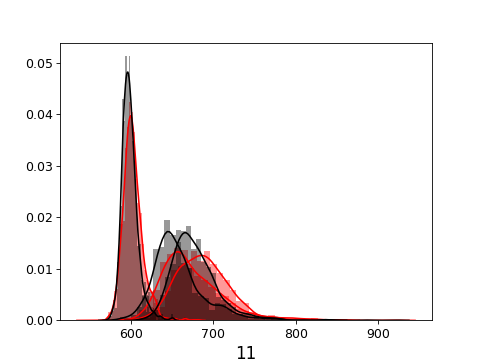

In [1404]:
pl.figure()
sns.distplot(trialmeans[1], color='r')
sns.distplot(trialmeans[239], color='r')
sns.distplot(trialmeans[11], color='r')

sns.distplot(trialbas[1], color='k')
sns.distplot(trialbas[239], color='k')
sns.distplot(trialbas[11], color='k')

In [1390]:
rlist = [r for r in trialmeans.columns if putils.isnumber(r)]
zs = (trialmeans[rlist] - trialmeans[rlist].mean()).divide(trialmeans[rlist].std())



<IPython.core.display.Javascript object>


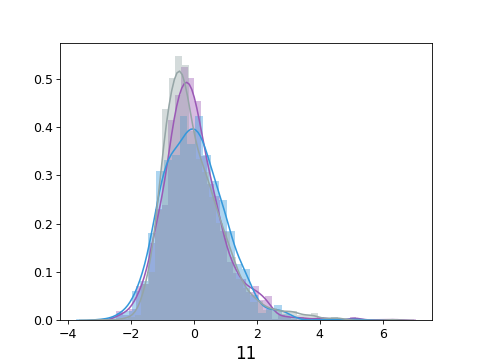

In [1393]:
pl.figure()
sns.distplot(zs[1])
sns.distplot(zs[239])

sns.distplot(zs[11])


In [1382]:

datakey = '_'.join([session, animalid, 'fov%i' % fovnum])
trial_means = MEANS[datakey]
#binned_traces = BINNED[datakey] # shape: (ntrials_total, nrois_total)

if experiment=='blobs':
    obj = util.Objects(animalid, session, 'FOV%i_zoom2p0x' %  fovnum, traceid=traceid)
elif experiment == 'gratings':
    obj = util.Gratings(animalid, session, 'FOV%i_zoom2p0x' %  fovnum, traceid=traceid)
sdf = obj.get_stimuli()

sdf.head()

Creating gratings object [JC084|20190522|FOV1_zoom2p0x|traces001]
... getting stimulus info for: combined_gratings_static


,aspect,direction,luminance,ori,position,sf,size,speed,stimtype,xpos,ypos
config001,1,0,None,0,"(0, 0)",0.1,200,10,gratings,0,0
config002,1,0,None,0,"(0, 0)",0.1,200,20,gratings,0,0
config003,1,0,None,0,"(0, 0)",0.5,200,10,gratings,0,0
config004,1,0,None,0,"(0, 0)",0.5,200,20,gratings,0,0
config005,1,0,None,0,"(20, -8)",0.1,20,10,gratings,20,-8


In [56]:

sizes = sorted(sdf['size'].unique())
morphlevels = sorted(sdf['morphlevel'].unique())             
config_array = np.reshape(sdf.index.tolist(), (10, 5))

<IPython.core.display.Javascript object>


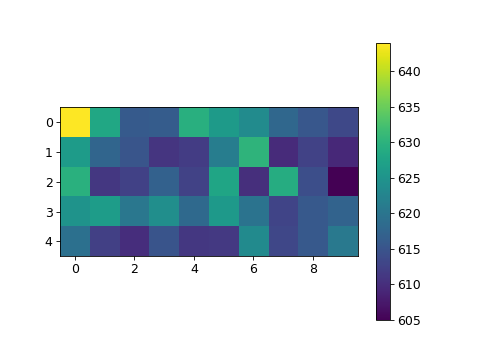

In [58]:
rid=39
tm = trial_means.groupby(['config']).mean()[rid].reshape(10,5).T
pl.figure()
pl.imshow(tm)
pl.colorbar()

#### For single rid, look at variabiltiy of activity

In [59]:
s_ons = bindict['stim_onsets']
stim_on = float(s_ons[s_ons['datakey']==datakey]['stim_on'])
n_on = int(round((bindict['params']['n_frames_on']/bindict['params']['framerate']) * bindict['params']['ds_framerate']))

print(stim_on, n_on)

NameError: name 'bindict' is not defined

In [50]:
rid = 17

<IPython.core.display.Javascript object>


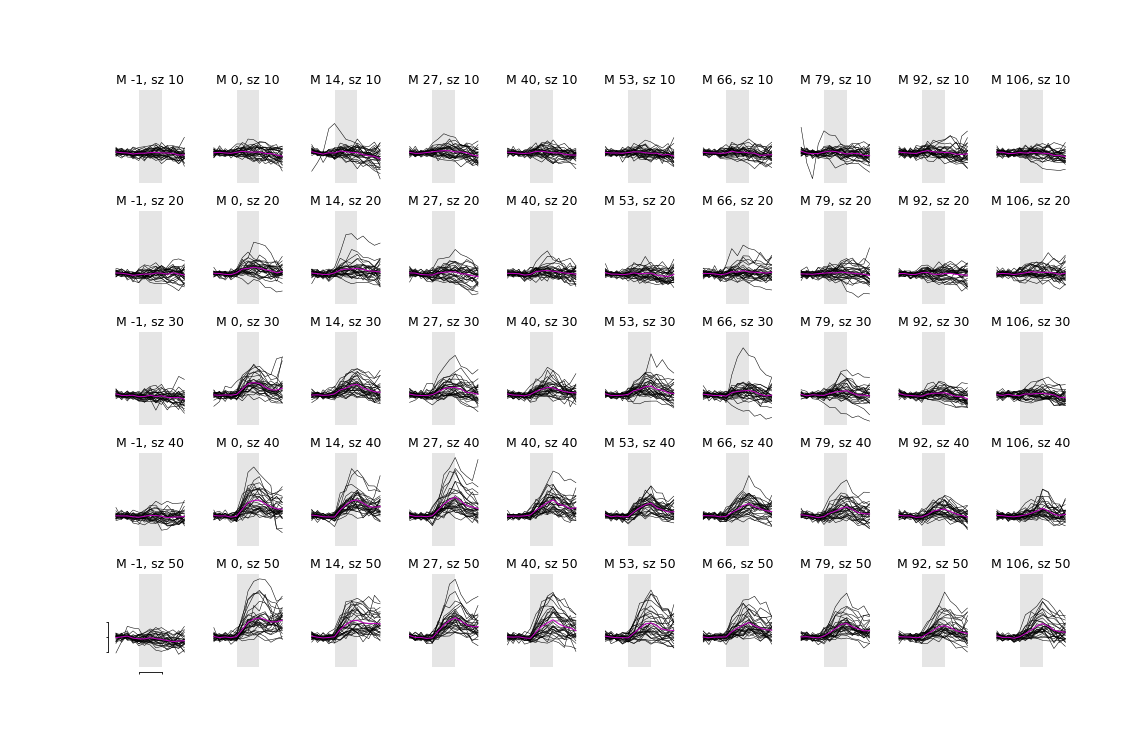

(4, 0)


In [122]:
stim_color = 'gray'
stim_alpha=0.2

fig, axn = pl.subplots(config_array.shape[1], config_array.shape[0], figsize=(15,10), sharex=True, sharey=True)
for cfg, cfg_traces in binned_traces.groupby(['config']): #.ravel()):
        
    morphlevel = sdf['morphlevel'][cfg]
    size = sdf['size'][cfg]
    title_str = 'M %i, sz %i' % (morphlevel, size)
    ri = sizes.index(size)
    ci = morphlevels.index(morphlevel)
    ax = axn[ri, ci]
    ax.set_title(title_str)
    
    n_frames = len(sorted(cfg_traces['frame_ix'].unique()))
    n_trials = len(sorted(cfg_traces['trial'].unique()))
    tmat = np.reshape(cfg_traces[rid].values, (n_trials, n_frames)) # shape (ntrials, nframes)
    t_df = pd.DataFrame(data=tmat.T, columns=sorted(cfg_traces['trial'].unique()), index=sorted(cfg_traces['frame_ix'].unique()))
    
    for tr in t_df:
        ax.plot(t_df[tr].values.T, 'k', lw=0.5)

    ax.plot(tmat.mean(axis=0), lw=1, color='m')
    if ci>0 or ri!=4:
        sns.despine(bottom=True, left=True, ax=ax)
        ax.tick_params(axis='both', which='both', size=0)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
    else:
        ax.set_xticks([stim_on, stim_on+n_on])
        ax.set_xticklabels(['', '%i s' % int(round(stim_on/bindict['params']['ds_framerate']))])
        sns.despine(offset=4, trim=True, ax=ax)
        print(ri, ci)
        ax.tick_params(axis='both', which='both', size=2, labelsize=16)
ymin, ymax = ax.get_ylim()
for ax in axn.flat:
    ax.add_patch(mpl.patches.Rectangle((stim_on, ymin), n_on, (ymax-ymin), linewidth=0,
                                 fill=True, color=stim_color, alpha=stim_alpha))
pl.subplots_adjust(wspace=0.3, hspace=0.3, left=0.1, right=0.95)

pl.suptitle("Cell %i" % int(rid+1))


## how to define variability?

In [45]:
trial_means.min().min()

-0.6792011685495475

In [60]:
trial_means = MEANS[datakey].copy()
trial_bas = BAS[datakey].copy()

variance_x_reps = trial_means.groupby(['config']).var()
means_x_reps = trial_means.groupby(['config']).mean()

variance_x_reps_bas = trial_bas.groupby(['config']).var()
means_x_reps_bas = trial_bas.groupby(['config']).mean()


d1 = variance_x_reps.unstack().reset_index().rename(columns={0: 'variance', 'level_0': 'rid'}).reset_index(drop=True)
d2 = means_x_reps.unstack().reset_index().rename(columns={0: 'mean', 'level_0': 'rid'}).reset_index(drop=True)

d1_y = variance_x_reps_bas.unstack().reset_index().rename(columns={0: 'variance_bas', 'level_0': 'rid'}).reset_index(drop=True)
d2_y = means_x_reps_bas.unstack().reset_index().rename(columns={0: 'mean_bas', 'level_0': 'rid'}).reset_index(drop=True)

d1['rel_var'] = d1['variance'].values/d1_y['variance_bas'].values
d2['rel_mean'] = d2['mean'].values/d2_y['mean_bas'].values

vardf = pd.merge(d1, d2)


<IPython.core.display.Javascript object>


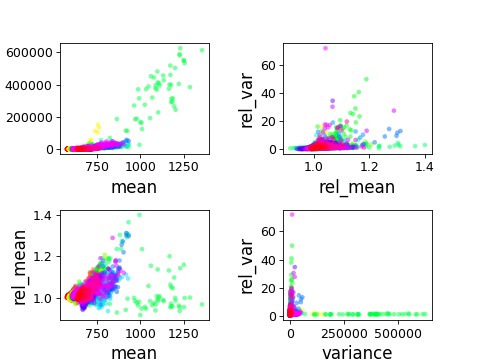

In [62]:
fig, axn = pl.subplots(2,2)
ax=axn[0,0]
sns.scatterplot(x='mean', y='variance', hue='rid', palette='hsv', data=vardf, ax=ax,
               marker='o', s=20, edgecolor='none', alpha=0.5, legend=0)
ax=axn[0,1]
sns.scatterplot(x='rel_mean', y='rel_var', hue='rid', palette='hsv', data=vardf, ax=ax,
               marker='o', s=20, edgecolor='none', alpha=0.5, legend=0)
ax=axn[1,0]
sns.scatterplot(x='mean', y='rel_mean', hue='rid', palette='hsv', data=vardf, ax=ax,
               marker='o', s=20, edgecolor='none', alpha=0.5, legend=0)
ax=axn[1,1]
sns.scatterplot(x='variance', y='rel_var', hue='rid', palette='hsv', data=vardf, ax=ax,
               marker='o', s=20, edgecolor='none', alpha=0.5, legend=0)
pl.subplots_adjust(hspace=0.5, wspace=0.5)


<IPython.core.display.Javascript object>


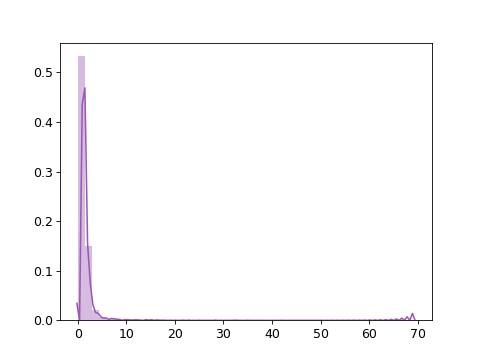

In [63]:
fig, ax = pl.subplots()
sns.distplot(vardf['rel_var']/vardf['rel_mean'])

## Downsampled, calculate activity correlations - test 1 fov

In [23]:
# Temporal binning params
n_frames_bin = 11.
framerate = 44.65
new_framerate = framerate/n_frames_bin
print("Downsampled fr: %.2f Hz" % new_framerate)

# Pupil alignment params
#pre_ITI_ms=500
#post_ITI_ms=500 #pre_ITI_ms
#epoch='trial_alignment'

#### Get indices of trial epochs to model
#pre_flank = round((pre_ITI_ms/1E3)*44.65) #n_on/2.
#post_flank = round((post_ITI_ms/1E3)*44.65)  #n_on


Downsampled fr: 4.06 Hz


<IPython.core.display.Javascript object>


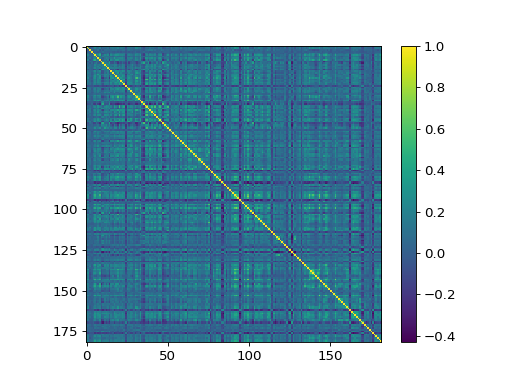

In [216]:
pl.figure()
pl.imshow(binned_traces[roi_list].corr())
pl.colorbar()

#### Check traces

In [205]:
rid = 5 #39 #roi_list[0]

# Create trial mat, downsampled: shape = (ntrials, nframes_per_trial)
trialmat = pd.DataFrame(np.vstack([traces[rid][tg.index] for trial, tg in labels.groupby(['trial'])]),\
                        index=[int(trial[5:]) for trial, tg in labels.groupby(['trial'])])
configs_on_included_trials = [tg['config'].unique()[0] for trial, tg in labels.groupby(['trial'])]
included_trials = [trial for trial, tg in labels.groupby(['trial'])]

#### Bin traces - Each tbin is a column, each row is a sample 
sample_data = trialmat.fillna(method='pad').copy()
binned_trialmat = sample_data.T.groupby(np.arange(len(sample_data.columns))//n_frames_bin, axis=0).mean().T
n_tbins = np.ceil(trialmat.shape[1] / n_frames_bin)

#### Zscore traces 
zscored_neural = binned_trialmat / binned_trialmat.values.ravel().std()

# Reshape roi traces
cfg_list = np.hstack([[c for _ in np.arange(0, n_tbins)] for c in configs_on_included_trials])
r_ = zscored_neural.T.unstack().reset_index() # level_0=trial number, level_1=frame number
r_.rename(columns={'level_0': 'trial', 'level_1': 'frame_ix', 0: rid}, inplace=True)
r_['config'] = cfg_list


In [206]:
# Check with known config, known RID
ml=53 #-1
sz=10
print(sdf[(sdf['morphlevel']==ml) & (sdf['size']==sz)])
cfg = sdf[(sdf['morphlevel']==ml) & (sdf['size']==sz)].index[0]
trial_ixs = np.array([int(t[5:]) for t in labels[labels['config']==cfg]['trial'].unique()])

          color morphlevel   object  size stimtype xpos ypos yrot
config026               53  morph53  10.0    image   20   -8    0


<IPython.core.display.Javascript object>


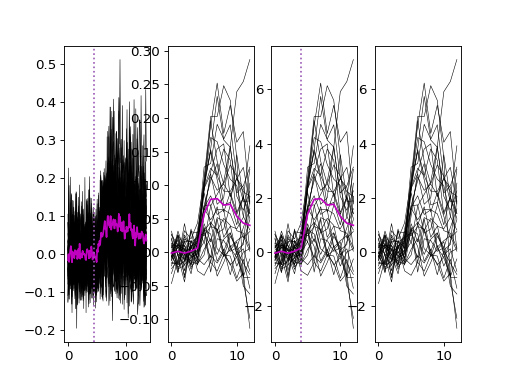

In [208]:
fig, axn = pl.subplots(1, 4, figsize=(6,3))
ax=axn[0]
ax.plot(trialmat.loc[trial_ixs].values.T, 'k', lw=0.5)
ax.plot(np.nanmean(trialmat.loc[trial_ixs].values.T, axis=1), 'm')
ax.axvline(x=stim_on, ls=':')

ax=axn[1]
ax.plot(binned_trialmat.loc[trial_ixs].values.T, 'k', lw=0.5)
ax.plot(np.nanmean(binned_trialmat.loc[trial_ixs].values.T, axis=1), 'm')

ax=axn[2]
ax.plot(zscored_neural.loc[trial_ixs].values.T, 'k', lw=0.5)
ax.plot(np.nanmean(zscored_neural.loc[trial_ixs].values.T, axis=1), 'm')
ax.axvline(x=new_stim_on, ls=':')

ax=axn[3]
for tr, g in df[df['config']==cfg].groupby(['trial']):
    ax.plot(g[rid].values.T, 'k', lw=0.5)

## Trial-to-trial correlations for each cell

In [1287]:
animalid = 'JC084'
session = '20190522'
fovnum = 1
datakey = '%s_%s_fov%i' % (session, animalid, fovnum)

#binned_traces = BINNED[datakey] # shape: (ntrials_total, nrois_total)


obj = util.Objects(animalid, session, 'FOV%i_zoom2p0x' %  fovnum, traceid=traceid)
sdf = obj.get_stimuli()

#n_frames = len(sorted(binned_traces['frame_ix'].unique()))
#n_trials = len(sorted(binned_traces['trial'].unique()))
#print(n_frames, n_trials)

config_array = np.reshape(sdf.index.tolist(), (10, 5))


Creating blobs object [JC084|20190522|FOV1_zoom2p0x|traces001]
... getting stimulus info for: combined_blobs_static


In [715]:
tmat.shape

NameError: name 'tmat' is not defined

<IPython.core.display.Javascript object>


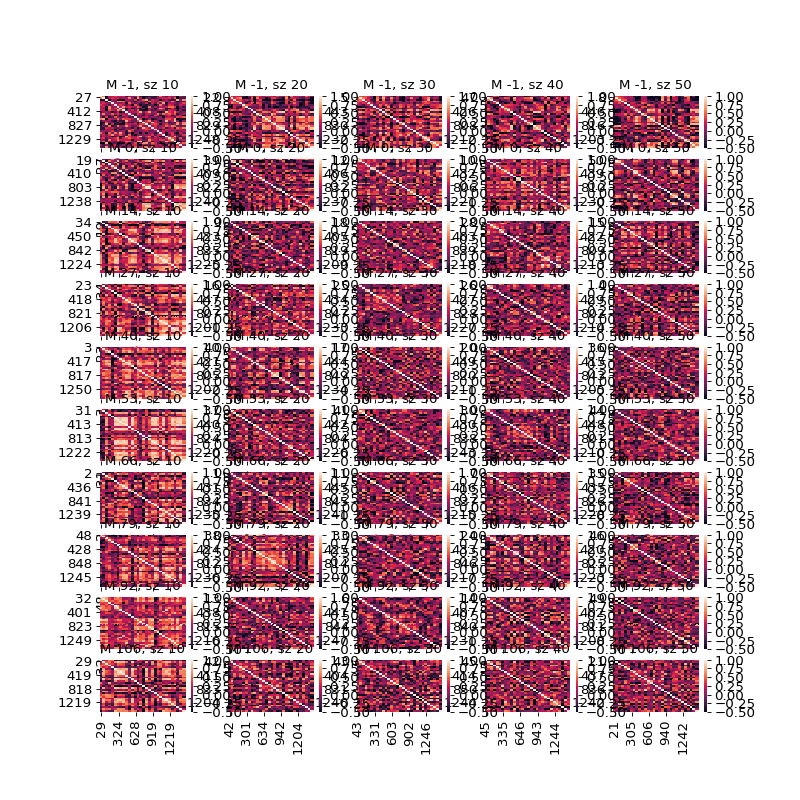

In [102]:


# cc_list = []
# fig, axn = pl.subplots(config_array.shape[0], config_array.shape[1], figsize=(10,10))
# for ax, cfg in zip(axn.flat, config_array.ravel()):
#     morphlevel = sdf['morphlevel'][cfg]
#     size = sdf['size'][cfg]
#     title_str = 'M %i, sz %i' % (morphlevel, size)
#     ax.set_title(title_str)
#     tr = binned_traces[binned_traces['config']==cfg] 
#     tmat = np.reshape(tr[rid].values, (n_trials, n_frames)) # shape (ntrials, nframes)
#     t_df = pd.DataFrame(data=tmat.T, columns=sorted(tr['trial'].unique()), index=sorted(tr['frame_ix'].unique()))
    
#     cc = melt_square_matrix(t_df.corr(), metric_name='corrcoef', include_diagonal=False)
#     cc['config'] = [cfg for _ in np.arange(0, cc.shape[0])]
#     cc_list.append(cc)
    
#     sns.heatmap(t_df.corr(), ax=ax, vmin=-0.5, vmax=1.0)
    

In [123]:
binned_traces.head()

,1,2,5,6,7,9,10,11,12,14,...,243,245,246,249,251,255,258,config,frame_ix,trial
0,1.427362,0.142272,0.184416,-0.402909,-1.290077,-0.307582,0.033549,-0.107203,0.296352,0.594323,...,0.132575,-0.680102,0.669116,0.668401,-0.652988,0.111374,-0.132679,config032,-0.0,1
1,-0.056254,-0.700513,0.417106,1.321581,0.087162,-0.323059,0.005261,0.577349,-0.362820,0.437404,...,1.615885,-0.268813,0.464228,-0.080755,0.274998,-0.428206,0.359121,config032,1.0,1
2,-0.675176,0.730704,-0.490220,-0.205744,0.182782,-0.026686,0.795037,-0.403678,0.008165,-0.216715,...,-1.818583,0.229261,-0.932626,-0.720344,0.448792,0.776866,0.411194,config032,2.0,1
3,-0.362193,-0.133808,-0.078889,-0.566045,0.685913,0.640618,-0.742506,-0.219362,-0.159651,-0.684630,...,0.220674,0.528405,-0.412144,-0.046739,-0.082468,-0.401760,-0.487119,config032,3.0,1
4,-1.023217,-0.050785,-0.267804,-0.355633,0.512487,0.370633,1.236171,1.322756,0.513791,0.611006,...,-0.995413,-2.066888,0.747665,0.844226,-0.650700,-0.198234,2.521133,config032,4.0,1


In [128]:
t_list=[]
roi_list = [r for r in binned_traces.columns if putils.isnumber(r)]
for rid in roi_list:
    cc_list = []
    for cfg in config_array.ravel():
        tr = binned_traces[binned_traces['config']==cfg]
        tmat = np.reshape(tr[rid].values, (n_trials, n_frames)) # shape (ntrials, nframes)
        t_df = pd.DataFrame(data=tmat.T, columns=sorted(tr['trial'].unique()), index=sorted(tr['frame_ix'].unique()))

        cc = putils.melt_square_matrix(t_df.corr(), metric_name='corrcoef', include_diagonal=False)
        cc['config'] = [cfg for _ in np.arange(0, cc.shape[0])]
        cc_list.append(cc)

    trialcorrs_by_cond = pd.concat(cc_list, axis=0)
    mean_trialcorrs_by_cond = trialcorrs_by_cond.groupby(['config']).mean()

    mean_trialcorrs_by_cond['rid'] = [rid for _ in np.arange(0, len(mean_trialcorrs_by_cond))]

    t_list.append(mean_trialcorrs_by_cond[['corrcoef', 'rid']].reset_index())


In [130]:
roi_trialcorrs = pd.concat(t_list,axis=0).reset_index(drop=True)
roi_trialcorrs.head()

,config,corrcoef,rid
0,config001,0.179017,1
1,config002,0.109830,1
2,config003,0.154946,1
3,config004,0.056117,1
4,config005,0.037183,1


In [ ]:
fig, axn = pl.subplots(config_array.shape[0], config_array.shape[1], figsize=(10,10))
for ax, cfg in zip(axn.flat, config_array.ravel()):
    morphlevel = sdf['morphlevel'][cfg]
    size = sdf['size'][cfg]
    title_str = 'M %i, sz %i' % (morphlevel, size)
    ax.set_title(title_str)
    sns.stripplot(x='rid', hue='rid', y='corrcoef', data=roi_trialcorrs[roi_trialcorrs['config']==cfg], ax=ax,
                 palette='hsv', dodge=True)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


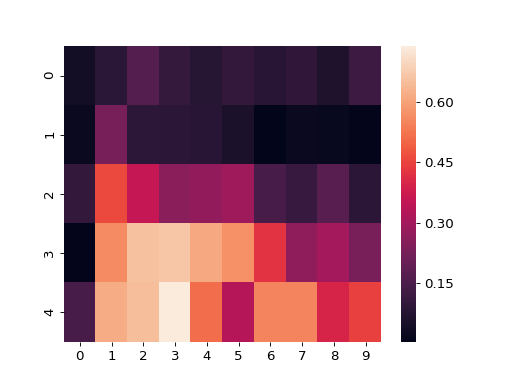

In [114]:
mean_arr = np.reshape(mean_trialcorrs_by_cond['corrcoef'].values,  (10, 5))
pl.figure()
sns.heatmap(mean_arr.T)